In [1]:
%%time
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import time
start = time.time()
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import cm
from matplotlib.colors import Normalize

data_set = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
pd.plotting.register_matplotlib_converters()

Wall time: 894 ms


In [2]:
%%time
df = pd.read_csv(data_set, low_memory=False)
df.date = df.date.apply(pd.to_datetime)

Wall time: 32.9 s


In [3]:
%%time
# Filters by continent
def return_continent(df, continent):
    mask = df['continent'].str.contains(continent, na=False)
    continent_df = df[mask].groupby('date').sum()
    continent_df['death_rate'] = continent_df.new_deaths/continent_df.new_cases
    continent_df['vaccination_rate'] = continent_df.people_fully_vaccinated/continent_df.population
    return continent_df

# Filters by country
def return_country(df, country):
    mask = df['location'].str.contains(country, na=False)
    country_df = df[mask].groupby('date').sum()
    country_df['death_rate'] = country_df.new_deaths/country_df.new_cases
    country_df['vaccination_rate'] = country_df.people_fully_vaccinated/country_df.population
    return country_df

# Ensures that all data in the timeframe is captured
def new_start(df1, df2):
    temp1 = df1[df1.new_vaccinations > 0]
    temp2 = df2[df2.new_vaccinations > 0]
    
    if temp1.index[0] < temp2.index[0]:
        return df1[df1.index >= temp1.index[0] - pd.to_timedelta(7, unit='d')], df2[df2.index >= temp1.index[0] - pd.to_timedelta(7, unit='d')]
    else:
        return df1[df1.index >= temp2.index[0] - pd.to_timedelta(7, unit='d')], df2[df2.index >= temp2.index[0] - pd.to_timedelta(7, unit='d')]
    
def before_vaccine(df1, df2):
    temp1 = df1[(df1.people_vaccinated == 0) & (df1.total_vaccinations == 0) & (df1.index < '2021-06-01')]
    temp2 = df2[(df2.people_vaccinated == 0) & (df2.total_vaccinations == 0) & (df2.index < '2021-06-01')]
    return temp1, temp2

Wall time: 0 ns


In [4]:
%%time
eur = return_continent(df, 'Europe')
nam = return_continent(df, 'North America')
eur_pre_vax, nam_pre_vax = before_vaccine(eur, nam)[0], before_vaccine(eur, nam)[1]

eur, nam = new_start(eur, nam)[0], new_start(eur, nam)[1]

eur_rolling = eur.rolling('14D').mean()
nam_rolling = nam.rolling('14D').mean()

Wall time: 294 ms


Wall time: 74 ms


Text(0.5, 0.1, 'All plots start from one week prior to the first day vaccines were administered in either region')

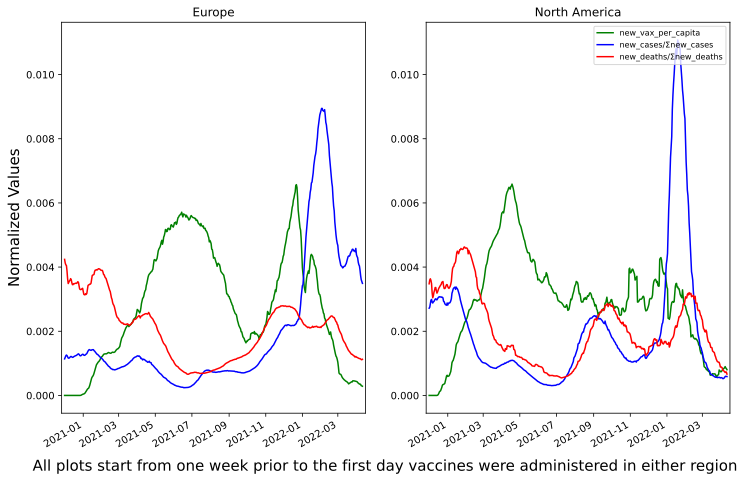

In [5]:
%%time
# Creating and formatting the figure
grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.3)
fig = plt.figure(figsize=(12, 8), dpi=100)
fig.subplots_adjust(wspace=0, hspace=0)

# Creating and formatting the subpots
ax1 = plt.subplot(grid[:, 0])
ax1.margins(x=0.01, y=0.01)
ax1.plot(eur_rolling.index, eur_rolling.new_vaccinations/eur_rolling.population, color='g')
ax1.plot(eur_rolling.index, eur_rolling.new_cases/sum(eur.new_cases), color='b')
ax1.plot(eur_rolling.index, eur_rolling.new_deaths/sum(eur.new_deaths), color='r')
ax1.title.set_text('Europe')
ax1.fmt_xdata = mdates.DateFormatter('%Y-%m')
plt.ylabel('Normalized Values', fontsize=15)

ax2 = plt.subplot(grid[:, 1], sharex=ax1, sharey=ax1)
ax2.margins(x=0.01)
ax2.plot(nam_rolling.index, nam_rolling.new_vaccinations/nam_rolling.population, color='g', label='new_vax_per_capita')
ax2.plot(nam_rolling.index, nam_rolling.new_cases/sum(nam.new_cases), color='b', label=f'new_cases/$\Sigma$new_cases')
ax2.plot(nam_rolling.index, nam_rolling.new_deaths/sum(nam.new_deaths), color='r', label=f'new_deaths/$\Sigma$new_deaths')
ax2.title.set_text('North America')
ax2.legend(loc='upper right', prop={'size': 8})

# Formatting the final output
fig.autofmt_xdate()
txt='All plots start from one week prior to the first day vaccines were administered in either region'
plt.figtext(0.5, .1, txt, wrap=True, horizontalalignment='center', fontsize=15)
#fig.savefig('EU_NA.jpg', dpi=200, bbox_inches = "tight")

In [6]:
%%time
usa = return_country(df, 'United States')
uae = return_country(df, 'United Arab Emirates')
usa_pre_vax, uae_pre_vax = before_vaccine(usa, uae)[0], before_vaccine(usa, uae)[1]

usa, uae = new_start(usa, uae)[0], new_start(eur, uae)[1]

usa_rolling = usa.rolling('14D').mean()
uae_rolling = uae.rolling('14D').mean()

Wall time: 182 ms


Wall time: 71 ms


Text(0.5, 0.1, 'All plots start from one week prior to the first day vaccines were administered in either region\n        United Arab Emirates selected due to highest per capita vaccinations')

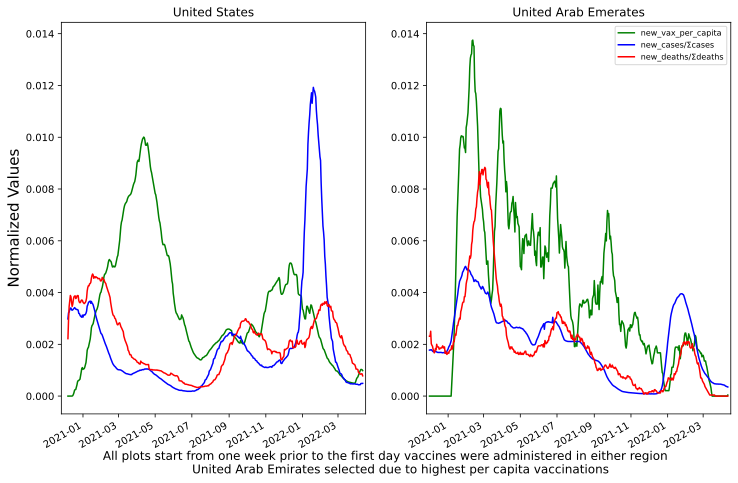

In [7]:
%%time
# Creating and formatting the figure
grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0)
fig = plt.figure(figsize=(12, 8), dpi=100)
fig.subplots_adjust(wspace=0, hspace=0)

# Creating and formatting the subpots
ax1 = plt.subplot(grid[:, 0])
ax1.margins(x=0.01, y=0.01)
ax1.plot(usa_rolling.index, usa_rolling.new_vaccinations/usa_rolling.population, color='g')
ax1.plot(usa_rolling.index, usa_rolling.new_cases/sum(usa.new_cases), color='b')
ax1.plot(usa_rolling.index, usa_rolling.new_deaths/sum(usa.new_deaths), color='r')
ax1.title.set_text('United States')
ax1.fmt_xdata = mdates.DateFormatter('%Y-%m')
plt.ylabel('Normalized Values', fontsize=15)

ax2 = plt.subplot(grid[:, 1], sharex=ax1, sharey=ax1)
ax2.margins(x=0.01)
ax2.plot(uae_rolling.index, uae_rolling.new_vaccinations/uae_rolling.population, color='g', label='new_vax_per_capita')
ax2.plot(uae_rolling.index, uae_rolling.new_cases/sum(uae.new_cases), color='b', label=f'new_cases/$\Sigma$cases')
ax2.plot(uae_rolling.index, uae_rolling.new_deaths/sum(uae.new_deaths), color='r', label=f'new_deaths/$\Sigma$deaths')
ax2.title.set_text('United Arab Emerates')
ax2.legend(loc='upper right', prop={'size': 8})

# Formatting the final output
fig.autofmt_xdate()
txt=r'''All plots start from one week prior to the first day vaccines were administered in either region
        United Arab Emirates selected due to highest per capita vaccinations'''
plt.figtext(0.5, .1, txt, wrap=True, horizontalalignment='center', fontsize=12)
#fig.savefig('USA_UAE.jpg', dpi=200, bbox_inches = "tight")

In [8]:
%%time
# This function normalizes the data and selects relevant columns
def df_for_corr(name, df):
    df_reset = df.reset_index()
    new_df = df_reset[['date','population','new_cases','new_deaths',
                       'hosp_patients','icu_patients', 'people_vaccinated',
                       'people_fully_vaccinated', 'total_boosters']]
    # Removing the first 2 months of vax_data instead of seven because the original data was shifted seven back to improve graph quality
    new_df = new_df[new_df.date >= new_df.date[0] + pd.to_timedelta(90, unit='d')]
    per_capita_df = new_df.iloc[:,2:].div(new_df.population, axis=0)
    per_capita_df = per_capita_df.loc[:, (per_capita_df != 0).any(axis=0)]
    per_capita_df.name = name
    return per_capita_df

# This function transforms color map -> found on matplotlib website
def cmap_map(function, cmap):
    cdict = cmap._segmentdata
    step_dict = {}
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))

    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
                
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
                
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector
        
    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

Wall time: 0 ns


In [9]:
eur_corr = df_for_corr('Europe', eur)
eur_pre_vax_corr = df_for_corr('Europe', eur_pre_vax)

nam_corr = df_for_corr('North America', nam)
nam_pre_vax_corr = df_for_corr('North America', nam_pre_vax)

usa_corr = df_for_corr('United States', usa)
usa_pre_vax_corr = df_for_corr('United States', usa_pre_vax)

uae_corr = df_for_corr('United Arab Emirates',uae)
uae_pre_vax_corr = df_for_corr('United Arab Emirates', uae_pre_vax)

In [10]:
def create_corr_mat_before_after(df_before_after):
    fig = plt.figure(figsize=(25,10))
    
    # Normalizing so that both frames are normalized using the same max
    mins = []
    maxs = []
    for i, dfs in enumerate(df_before_after):
        df = dfs
        corr = df.corr()
        mins.append(corr.min().min())
        maxs.append(corr.max().max())
        
    # Creating and formatting the subpots
    for i, dfs in enumerate(df_before_after):
        df = dfs
        corr = df.corr()
        ax = fig.add_subplot(1, 2, i+1)
        norm = Normalize(-1, 1)
        cmap = cmap_map(lambda x: 1.1*x, matplotlib.cm.RdYlGn_r)
        fontdict={'verticalalignment': 'bottom',
                  'horizontalalignment': 'left',
                  'rotation': 45}

        cax = ax.matshow(df.corr(),interpolation='nearest', cmap=cmap, norm=norm)
        for (i, j), z in np.ndenumerate(corr):
            plt.text(j, i, '{:0.3f}'.format(z),fontsize=20, horizontalalignment='center',
                                                             verticalalignment='center')
            
        ax.set_xticks(range(df.select_dtypes(['number']).shape[1]))
        ax.set_xticklabels(labels = df.select_dtypes(['number']).columns, fontdict=fontdict)
        
        ax.set_yticks(range(df.select_dtypes(['number']).shape[1]))
        ax.set_yticklabels(df.select_dtypes(['number']).columns, fontsize=20, rotation = 53)

        ax.tick_params(axis='both', which='major', labelsize=17)
    
    for i in fig.axes:
        i.set_aspect('auto')
        
    cb = fig.colorbar(cax)
    cb.ax.tick_params(labelsize=14)
    
    txt=f'''
    {df.name} Correlation Matrices:
    \u2022Matrix with vax data considers data starting two months after first
      doses were administered
    \u2022Matrix with no vax data is from before any vaccines were
      administered'''
    
    plt.figtext(.115, 1.005, txt, weight='bold', horizontalalignment='left', fontsize=15)
    
    txt=f'''NOTE: red does not necessarily mean "bad". For example "people_vaccinated" and "people_fully_vaccinated" are red. 
           \u2022Correlations are based on per-capita data, so that population did not weigh excessively on results; per_capita_col = col/population
           \u2022Colormapping was normalized linearly (-1,1)
           \u2022The correlation matrix for data collected before vaccination serves as a control for all values found in both matricies'''
    plt.figtext(.125, 0.005, txt, wrap=True, horizontalalignment='left', fontsize=15, weight='bold', backgroundcolor='w')
    #fig.savefig(f'{df.name}_corr_mat.jpg', dpi=200, bbox_inches = "tight")

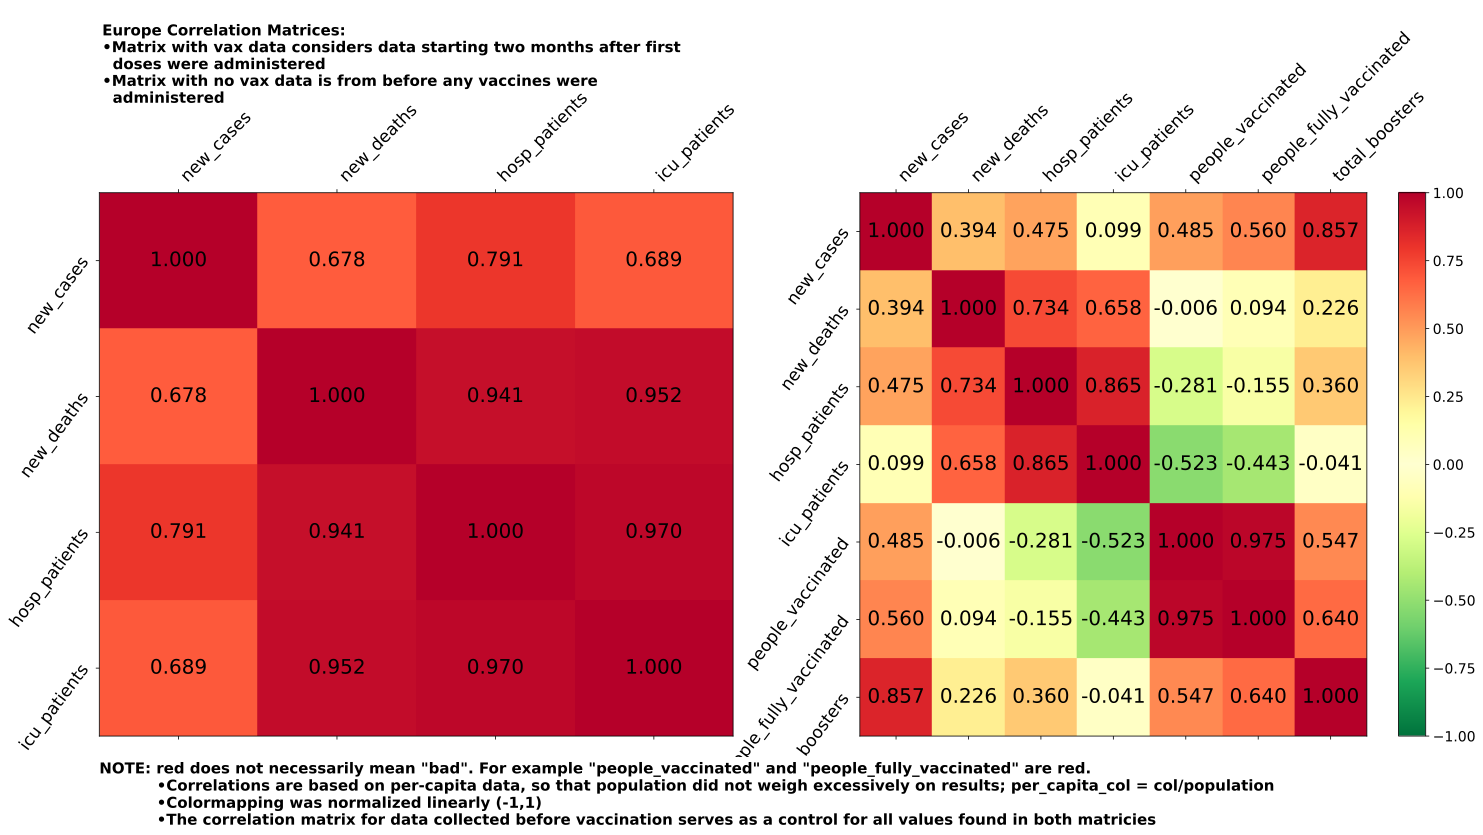

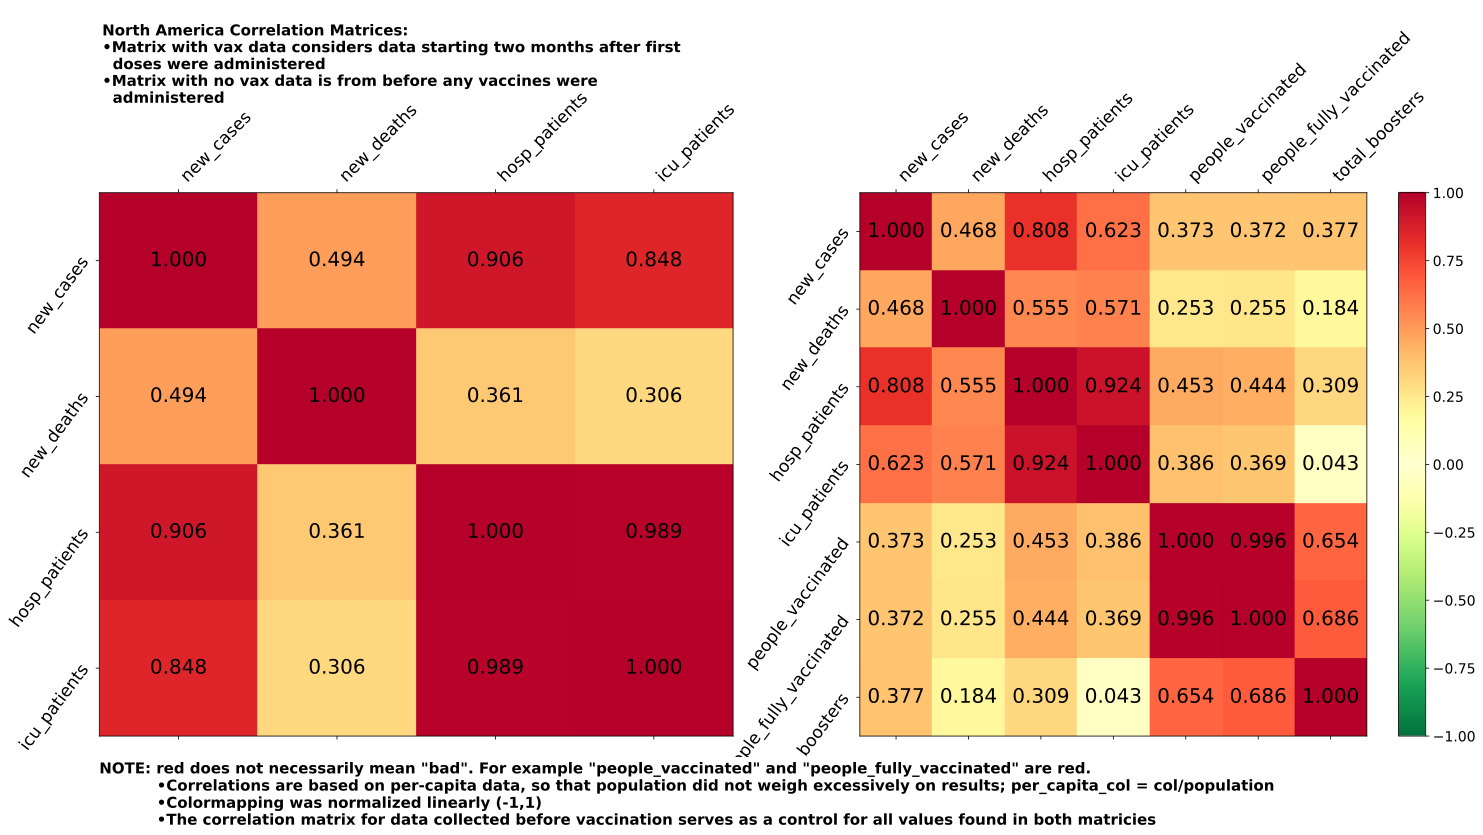

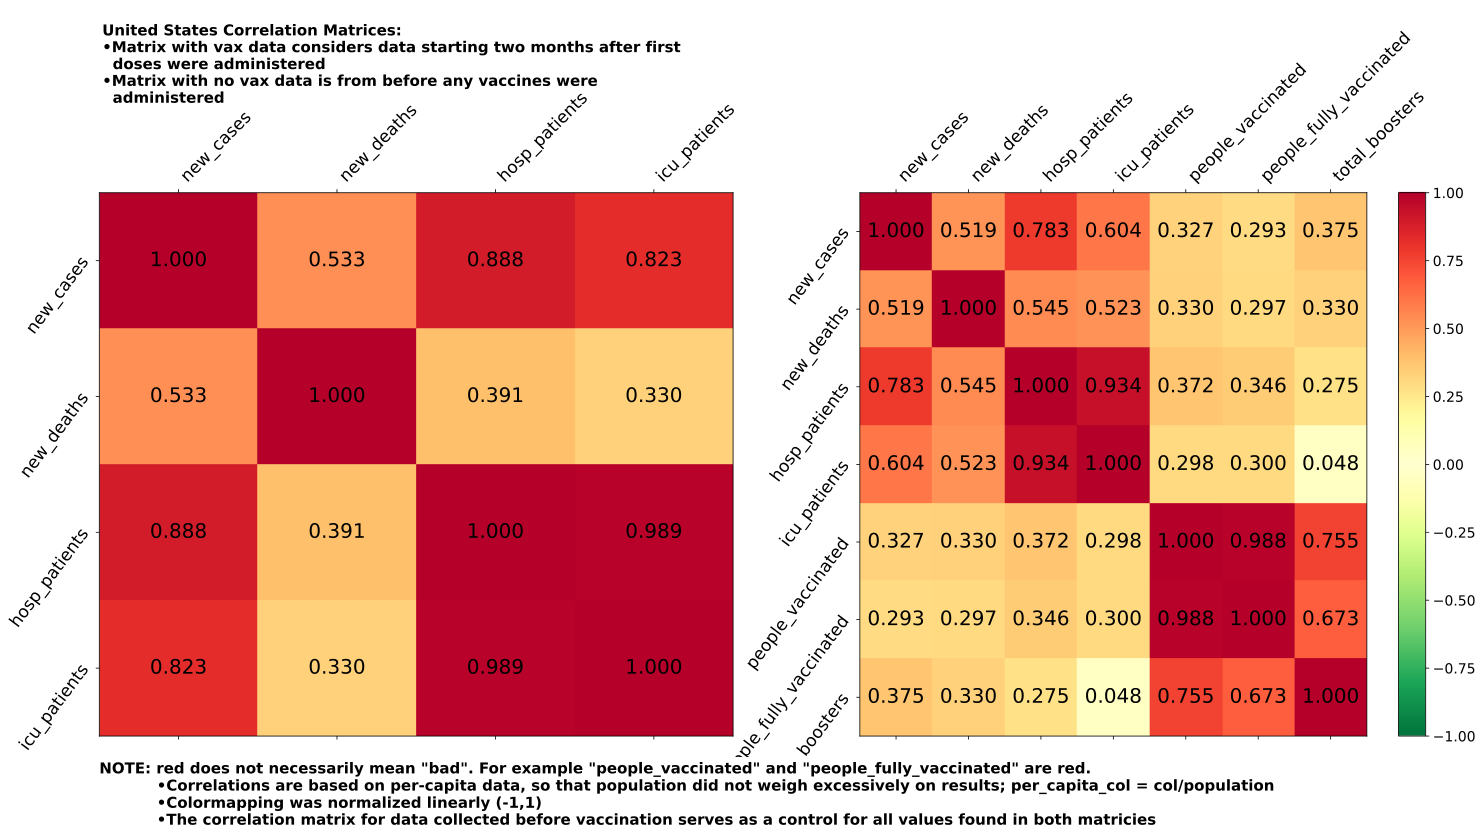

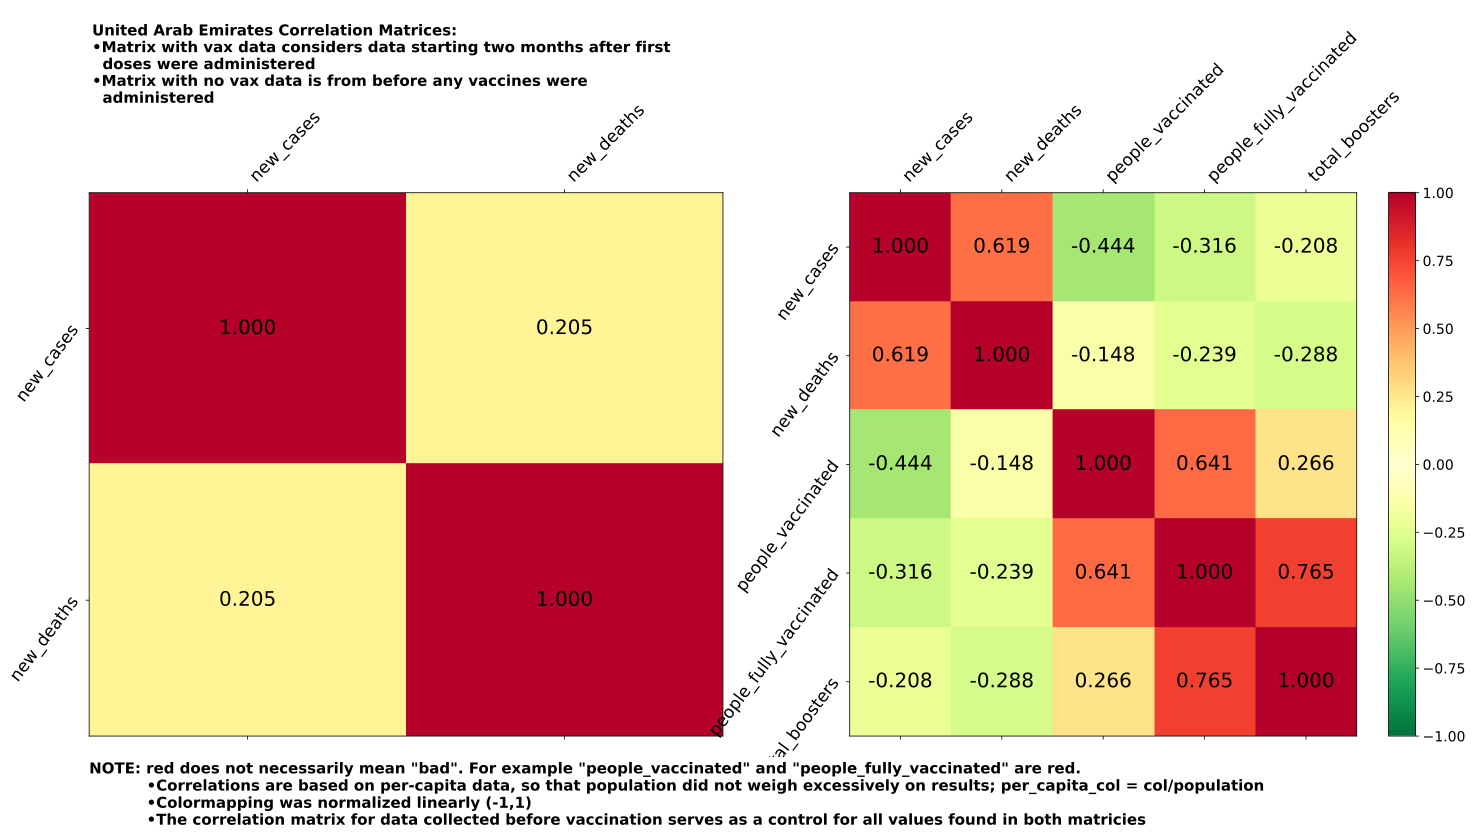

In [11]:
create_corr_mat_before_after([eur_pre_vax_corr, eur_corr])
create_corr_mat_before_after([nam_pre_vax_corr, nam_corr])
create_corr_mat_before_after([usa_pre_vax_corr, usa_corr])
create_corr_mat_before_after([uae_pre_vax_corr, uae_corr])

In [12]:
%%time
end = time.time()
min_sec = divmod(end-start, 60)

print(f'total time to run notebook: {min_sec[0]:.0f} min {min_sec[1]:.0f} sec')

total time to run notebook: 0 min 44 sec
Wall time: 0 ns
